In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [6]:
# Load data
train_set = pd.read_csv("train_cleandata.csv")
test_set = pd.read_csv("test_cleandata.csv")

# Convert categorical variables to categorical dtype
categorical_cols = ["quarter", "day", "team", "department"]
train_set[categorical_cols] = train_set[categorical_cols].astype("category")
test_set[categorical_cols] = test_set[categorical_cols].astype("category")

# Define predictors
department_predictors = [
    "targeted_productivity", "smv", "over_time", "incentive",
    "idle_time", "idle_men", "no_of_workers", "team"
]

department_predictors_sewing = [
    "targeted_productivity", "incentive",
    
]

department_predictors_finishing = [
       "targeted_productivity", "smv", "over_time", "no_of_workers", "team"
]

overall_predictors = department_predictors + ["department"]

In [7]:
# Configuration
DEPARTMENTS = {
    "Sewing": department_predictors_sewing,
    "Finishing": department_predictors_finishing,
    "Overall": overall_predictors
}

# Replace Isolation Forest with tuned version
OUTLIER_METHODS = {
    "isolation_forest": IsolationForest(
        contamination=0.1,            # Increased from 0.05
        n_estimators=200, 
        max_features=0.8,
        random_state=42
    ),
    "none": None
}

# Advanced Parameter Grid with Regularization
RANDOM_FOREST_PARAMS = {
    'n_estimators': [300, 400, 500],  # Increased ensemble size
    'max_depth': [5, 8, 10, None],    # Shallower trees
    'min_samples_split': [8, 10, 15], # More samples required for splits
    'min_samples_leaf': [6, 8, 10],   # Larger leaf sizes
    'max_features': [0.5, 0.6, 'sqrt'],  # Reduced feature space
    'max_leaf_nodes': [50, 100, None], # Direct leaf control
    'bootstrap': [True],              # Maintain diversity
    'ccp_alpha': [0.0, 0.01, 0.1]    # Cost complexity pruning
}

def detect_outliers(data, method):
    """Detect outliers using specified method"""
    if method == "none":
        return data
    
    detector = OUTLIER_METHODS[method]
    numeric_cols = data.select_dtypes(include=np.number).columns
    detector.fit(data[numeric_cols])
    inliers = detector.predict(data[numeric_cols]) == 1
    return data[inliers]

def prepare_data(train, test, predictors, outlier_method):
    """Preprocess data with specified outlier handling and label encoding"""
    # Detect and remove outliers
    train_clean = detect_outliers(train, outlier_method)
    test_clean = detect_outliers(test, outlier_method)
    
    # Separate features and target
    X_train = train_clean[predictors].copy()
    X_test = test_clean[predictors].copy()
    y_train = train_clean["actual_productivity"]
    y_test = test_clean["actual_productivity"]
    
    # Apply label encoding to categorical columns
    categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        label_encoders[col] = le
    
    return X_train, X_test, y_train, y_test, label_encoders

def train_rf_model(X_train, y_train):
    """Train Random Forest with advanced regularization"""
    rf = RandomForestRegressor(random_state=42, oob_score=True)
    
    search = RandomizedSearchCV(
        rf, RANDOM_FOREST_PARAMS,
        n_iter=100,                   # Increased search iterations
        cv=5,                         # More validation folds
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        error_score='raise'
    )
    
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Calculate and return evaluation metrics"""
    return {
        "train_mse": mean_squared_error(y_train, model.predict(X_train)),
        "test_mse": mean_squared_error(y_test, model.predict(X_test)),
        "train_r2": r2_score(y_train, model.predict(X_train)),
        "test_r2": r2_score(y_test, model.predict(X_test))
    }

def run_analysis(department, outlier_method):
    """Complete analysis pipeline using label encoding"""
    # Get appropriate data
    if department == "Overall":
        train = train_set
        test = test_set
    else:
        train = train_set[train_set["department"] == department.lower()]
        test = test_set[test_set["department"] == department.lower()]
    
    # Prepare data with label encoding
    X_train, X_test, y_train, y_test, label_encoders = prepare_data(
        train, test, DEPARTMENTS[department], outlier_method
    )
    
    # Train model with tuning
    best_model, best_params = train_rf_model(X_train, y_train)
    
    # Evaluate
    metrics = evaluate_model(
        best_model,
        X_train,
        X_test,
        y_train,
        y_test
    )
    
    # Feature importance visualization
    feature_names = X_train.columns
    importance = pd.Series(best_model.feature_importances_, index=feature_names)
    importance = importance.sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    importance.plot(kind='barh', color='steelblue')
    plt.title(f'{department} Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    
    return {
        "department": department,
        "outlier_method": outlier_method,
        "best_params": best_params,
        "label_encoders": label_encoders,
        **metrics
    }



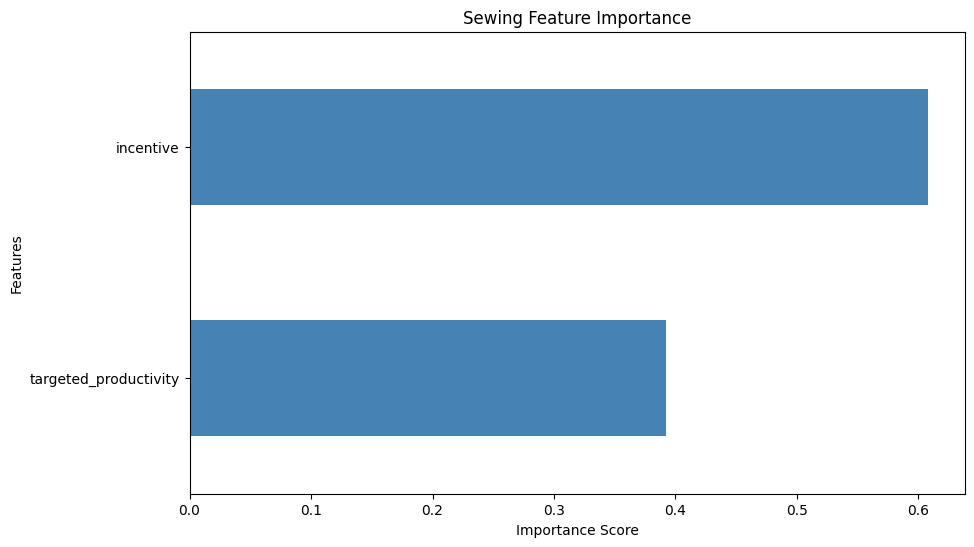

{'department': 'Sewing', 'outlier_method': 'isolation_forest', 'best_params': {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_leaf_nodes': None, 'max_features': 0.5, 'max_depth': None, 'ccp_alpha': 0.0, 'bootstrap': True}, 'label_encoders': {}, 'train_mse': 0.002899305768787509, 'test_mse': 0.0034378214846543615, 'train_r2': 0.8279254899131018, 'test_r2': 0.794347829479616}


In [8]:
# Example usage for Finishing department without outlier removal
random.seed(42)
sewing_no_outlier_result = run_analysis("Sewing", "isolation_forest")

# Print results
print(sewing_no_outlier_result)